<div style="background-color: lightgrey; padding: 20px; border-radius: 30px; color: green;">
    <h1 align = "center" > <u>SEGMENTATION DE LA CLIENTELLE AVEC L'ALGORITHME S-NN (Shared Nearest Neighbor)</u></h1>
</div>

# <u>Rappel</u>
### a- Pour chaque point on identifie ses K plus proches voisins
### b- Pour chaque paire de point on calcul le nombre de voisin qu'ils partagent en commun
### c- On construit un graphe dans lequel on represente les points de données par des sommets avec leurs arretes qui represente la similarité entre deux points
### d- On forme les clusters en regroupant ensembles les points points similaires (points qui partagent un nombre de voisin commun superieur a un seuil)

# 1- <u>Objectif</u>
Le but de cet application est de faire une **Segmentation de la Clientèle** a partir du dataset $Transactions$ disponible a l'adresse suivante : https://www.kaggle.com/datasets/ranjeetshrivastav/fraud-detection-dataset. Ce jeu de données contient les informations des transactions bancaires de certains clients. l'objectif est d'identifier des groupes de clients ayant des comportements de dépenses similaires. Cela pourrais par exemple nous aider à personnaliser les offres et les promotions, améliorer le service client, et identifier les clients à risque de défaut de paiement. On pourrait entre autre trouver:
- Les Clients avec haute limite de crédit et haute solvabilité : Potentiellement des clients VIP.
- Les Clients à faible solde et hauts montants de transactions : Risque potentiel de défaut de paiement.
- Les Clients avec limite de crédit moyenne et solde élevé : Bon potentiel pour des offres de crédit supplémentaires.

Le dataset contient les informations suivantes:

- **Identifiants et Informations de Compte**
    - accountNumber : Numéro de compte unique attribué à chaque client.
    - customerId : Identifiant unique pour chaque client.
    - creditLimit : Limite de crédit disponible pour le client.
    - availableMoney : Montant d'argent disponible sur le compte du client.
    - accountOpenDate : Date d'ouverture du compte
    - dateOfLastAddressChange : Date du dernier changement d'adresse du client.
- **Transactions et Dépenses**
    - transactionDateTime : Date et heure de la transaction.
    - transactionAmount : Montant de la transaction effectuée.
    - transactionType : Type de transaction (e.g., achat, retrait).
    - currentBalance : Solde actuel du compte du client.
    - isFraud : Indicateur de transaction frauduleuse (oui/non).
- **Détails du Marchand et Géographiques**
    - merchantName : Nom du commerçant où la transaction a eu lieu.
    - acqCountry : Pays où la transaction a été acquittée.
    - merchantCountryCode : Code pays du commerçant.
    - merchantCity : Ville du commerçant.
    - merchantState : État ou région du commerçant.
    - merchantZip : Code postal du commerçant.
    - merchantCategoryCode : Code de la catégorie du marchand.
- **Informations de Point de Vente et de Sécurité**
    - posEntryMode : Mode d'entrée de la transaction au point de vente (e.g., carte présentée, code CVV).
    - posConditionCode : Code de condition du point de vente.
    - posOnPremises : Indicateur si la transaction a eu lieu sur les lieux du commerçant (oui/non).
    - cardPresent : Indicateur si la carte physique était présente lors de la transaction (oui/non).
    - recurringAuthInd : Indicateur d'autorisation récurrente pour les transactions répétitives.
    - expirationDateKeyInMatch : Correspondance de la date d'expiration de la carte.
    - currentExpDate : Date de péremption actuelle de la carte.
- **Informations Additionnelles et Sécurité de la Carte**
    - cardCVV : Code de vérification de la carte.
    - enteredCVV : Code CVV entré par le client.
    - cardLast4Digits : Derniers 4 chiffres de la carte.
    - echoBuffer : Tampon d'écho pour les données supplémentaires de la transaction.`

# 2- <u>Importation des bibliotheques</u>

In [26]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import pairwise_distances
from scipy.sparse import csr_matrix
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score


# 3- <u>Analyses et prétraitement des donnees</u>

## 3-1- Importation des données

In [2]:
with open('transactions.txt', 'r') as file:
    data = [json.loads(line) for line in file]

df_transactions = pd.DataFrame(data)


In [3]:
df_transactions.head()
4

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000.0,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,,0.0,,,,False,,,False,False
1,737265056,737265056,5000.0,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,,0.0,,,,True,,,False,False
2,737265056,737265056,5000.0,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
3,737265056,737265056,5000.0,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
4,830329091,830329091,5000.0,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,...,,0.0,,,,True,,,False,False


## 3-2- Description des donnees

In [4]:
df_transactions.describe(include = "all")


,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
count,786363,786363,786363.000000,786363.000000,786363,786363.000000,786363,786363,786363,786363,...,786363,786363.000000,786363,786363,786363,786363,786363,786363,786363,786363
unique,5000,5000,NaN,NaN,776637,NaN,2490,5,5,6,...,1,NaN,1,1,1,2,1,1,2,2
top,380680241,380680241,NaN,NaN,2016-12-25T14:04:15,NaN,Uber,US,US,05,...,,NaN,,,,False,,,False,False
freq,32850,32850,NaN,NaN,4,NaN,25613,774709,778511,315035,...,786363,NaN,786363,786363,786363,433495,786363,786363,785320,773946
mean,NaN,NaN,10759.464459,6250.725369,NaN,136.985791,NaN,NaN,NaN,NaN,...,NaN,4508.739089,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,11636.174890,8880.783989,NaN,147.725569,NaN,NaN,NaN,NaN,...,NaN,6457.442068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,250.000000,-1005.630000,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,5000.000000,1077.420000,NaN,33.650000,NaN,NaN,NaN,NaN,...,NaN,689.910000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,7500.000000,3184.860000,NaN,87.900000,NaN,NaN,NaN,NaN,...,NaN,2451.760000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,15000.000000,7500.000000,NaN,191.480000,NaN,NaN,NaN,NaN,...,NaN,5291.095000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3-3- Verifications des valeurs manquantes

In [5]:
df_transactions.isnull().sum()


accountNumber               0
customerId                  0
creditLimit                 0
availableMoney              0
transactionDateTime         0
transactionAmount           0
merchantName                0
acqCountry                  0
merchantCountryCode         0
posEntryMode                0
posConditionCode            0
merchantCategoryCode        0
currentExpDate              0
accountOpenDate             0
dateOfLastAddressChange     0
cardCVV                     0
enteredCVV                  0
cardLast4Digits             0
transactionType             0
echoBuffer                  0
currentBalance              0
merchantCity                0
merchantState               0
merchantZip                 0
cardPresent                 0
posOnPremises               0
recurringAuthInd            0
expirationDateKeyInMatch    0
isFraud                     0
dtype: int64

In [6]:
df_transactions.dtypes


accountNumber                object
customerId                   object
creditLimit                 float64
availableMoney              float64
transactionDateTime          object
transactionAmount           float64
merchantName                 object
acqCountry                   object
merchantCountryCode          object
posEntryMode                 object
posConditionCode             object
merchantCategoryCode         object
currentExpDate               object
accountOpenDate              object
dateOfLastAddressChange      object
cardCVV                      object
enteredCVV                   object
cardLast4Digits              object
transactionType              object
echoBuffer                   object
currentBalance              float64
merchantCity                 object
merchantState                object
merchantZip                  object
cardPresent                    bool
posOnPremises                object
recurringAuthInd             object
expirationDateKeyInMatch    

## 3-4- Distribution

### 3-4-1- Variables categorielles

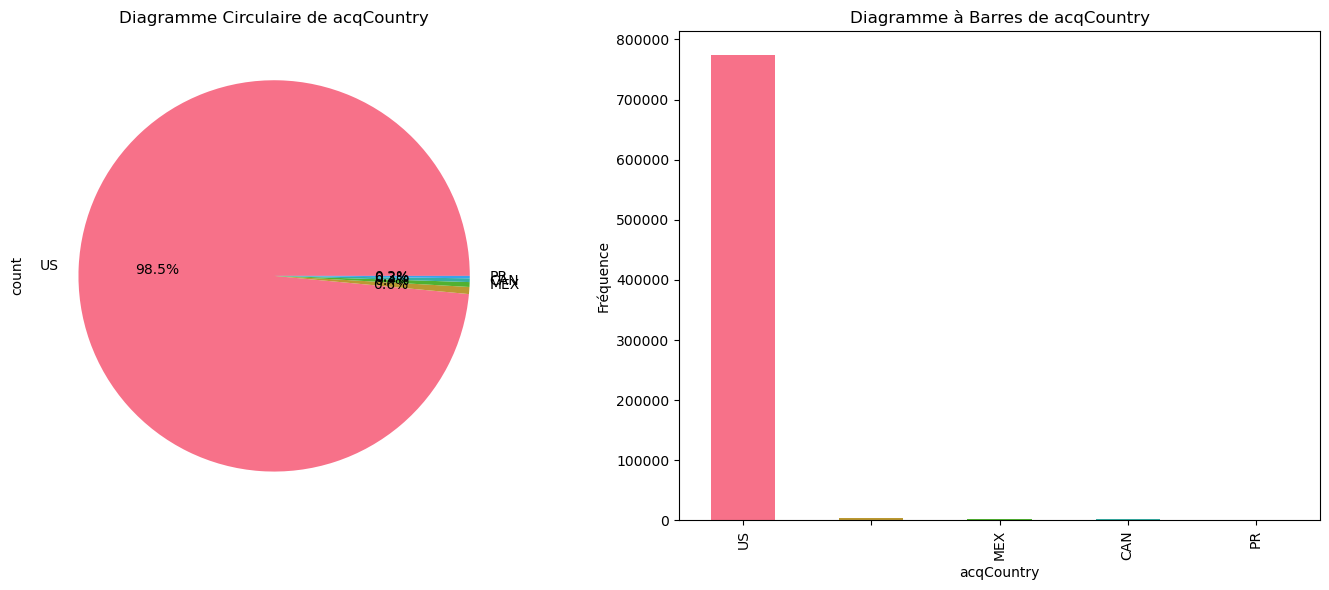

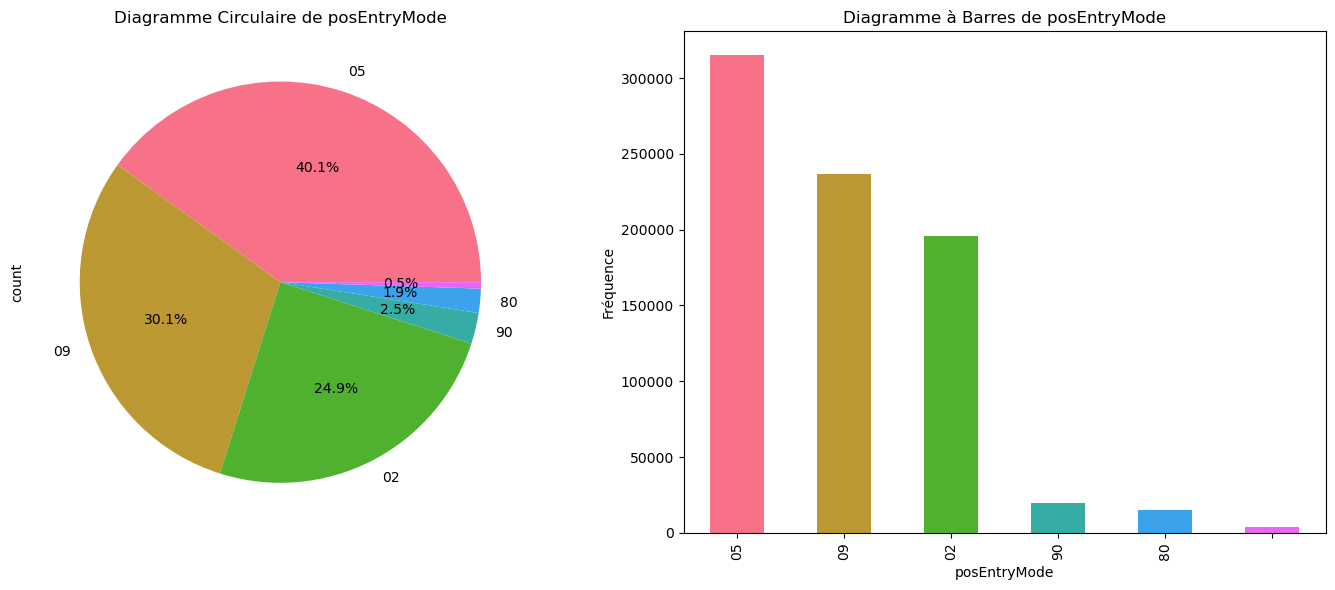

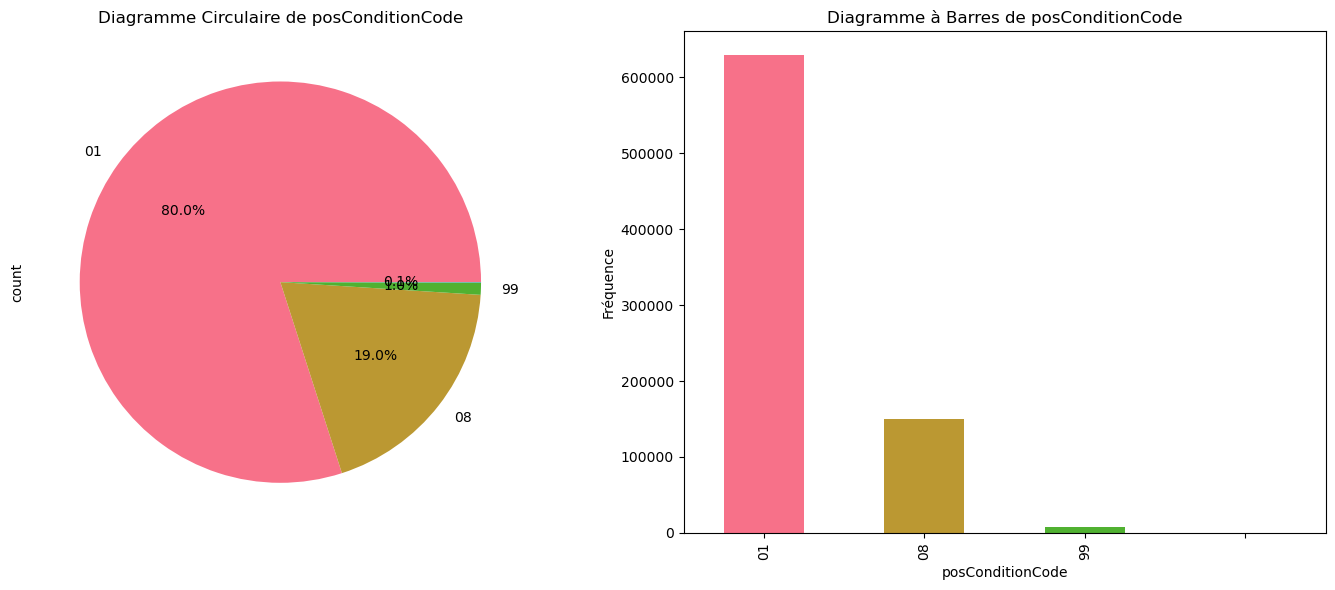

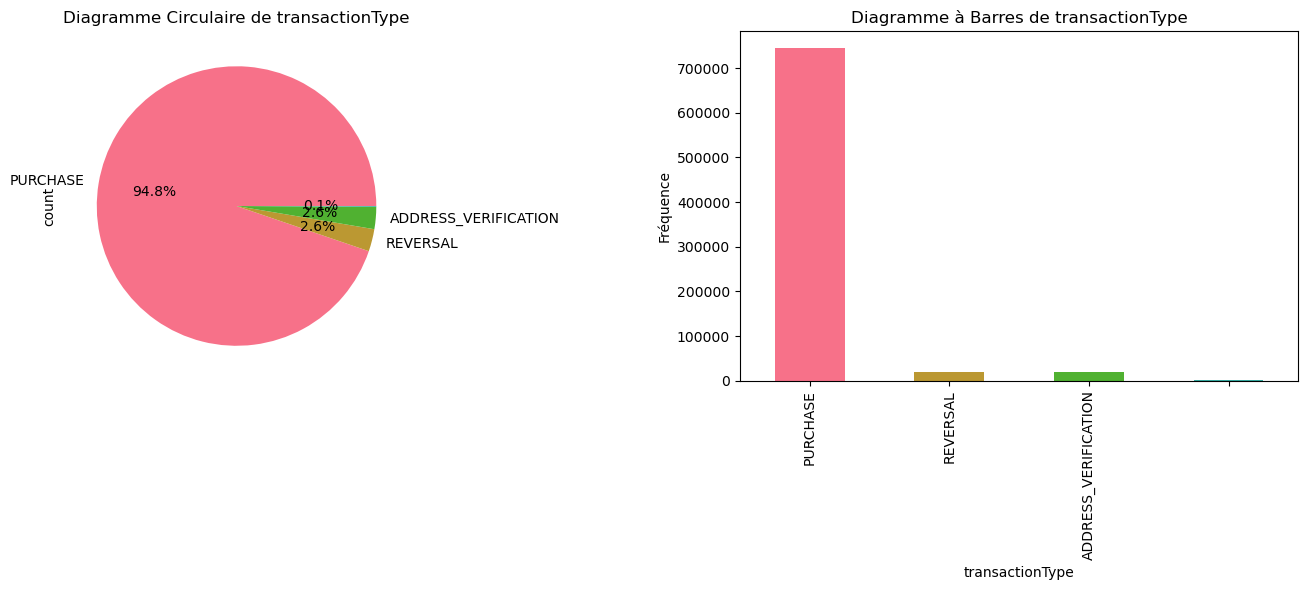

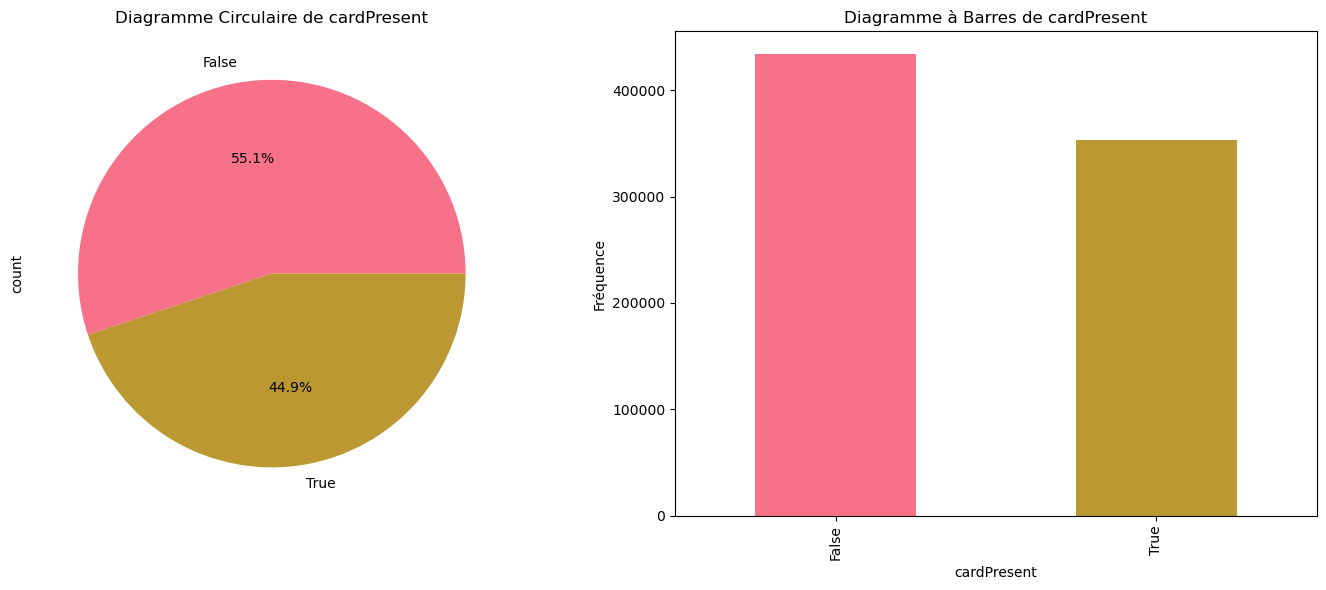

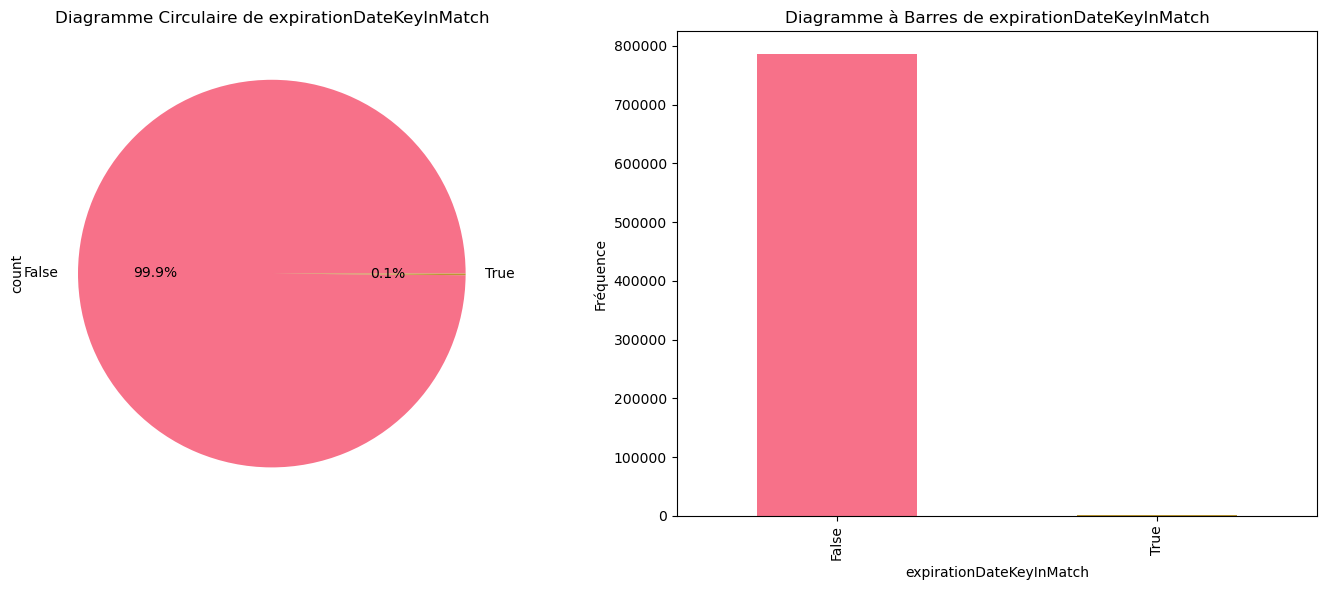

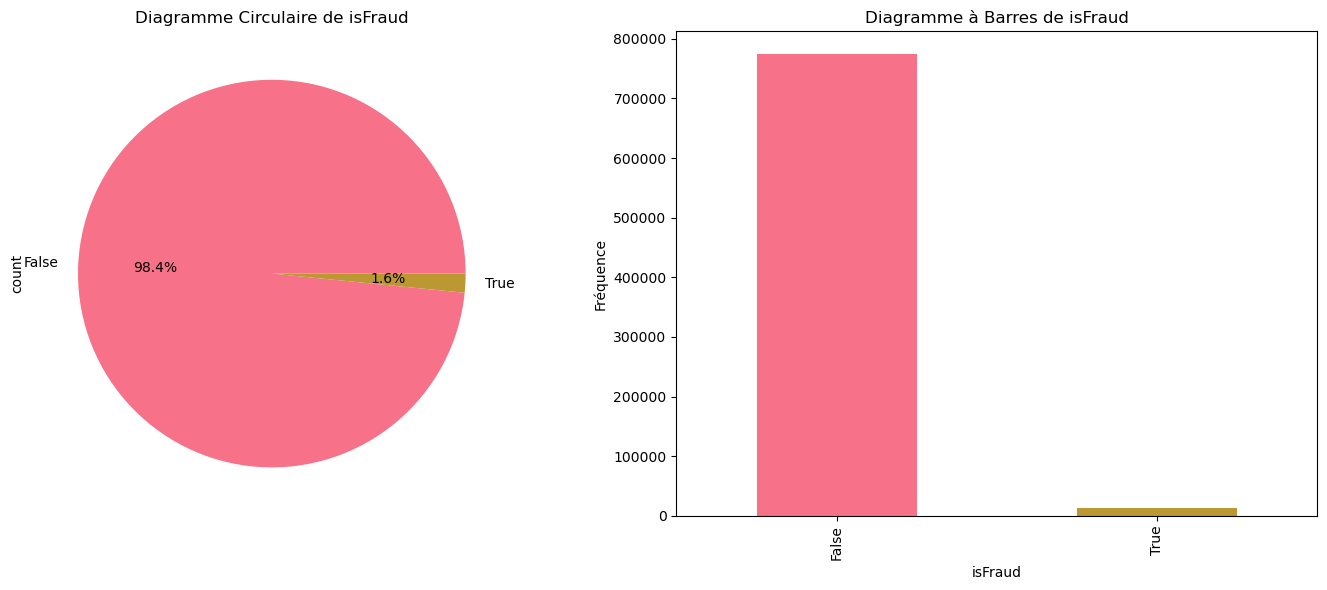

In [7]:
# Variables categorielles
cat_vars = df_transactions[["acqCountry","posEntryMode","posConditionCode","transactionType","cardPresent","expirationDateKeyInMatch","isFraud"]]

# Diagrammes Circulaires et à Barres
for var in cat_vars:
    plt.figure(figsize=(14, 6))
    
    # Diagramme Circulaire
    plt.subplot(1, 2, 1)
    df_transactions[var].value_counts().plot.pie(autopct='%1.1f%%', colors=sns.color_palette('husl'))
    plt.title(f'Diagramme Circulaire de {var}')
    
    # Diagramme à Barres
    plt.subplot(1, 2, 2)
    df_transactions[var].value_counts().plot.bar(color=sns.color_palette('husl'))
    plt.title(f'Diagramme à Barres de {var}')
    plt.xlabel(var)
    plt.ylabel('Fréquence')
    
    plt.tight_layout()
    plt.show()
    

Text(0, 0.5, 'Fréquence')

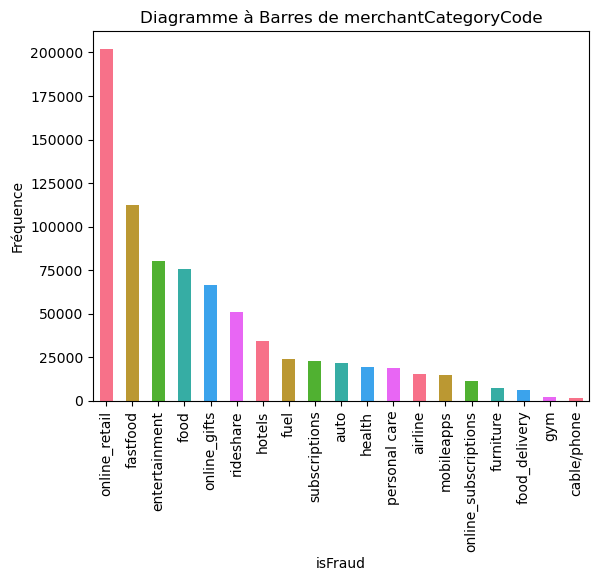

In [8]:
df_transactions["merchantCategoryCode"].value_counts().plot.bar(color=sns.color_palette('husl'))
plt.title(f'Diagramme à Barres de merchantCategoryCode')
plt.xlabel(var)
plt.ylabel('Fréquence')


### 3-4-2- Variables numeriques

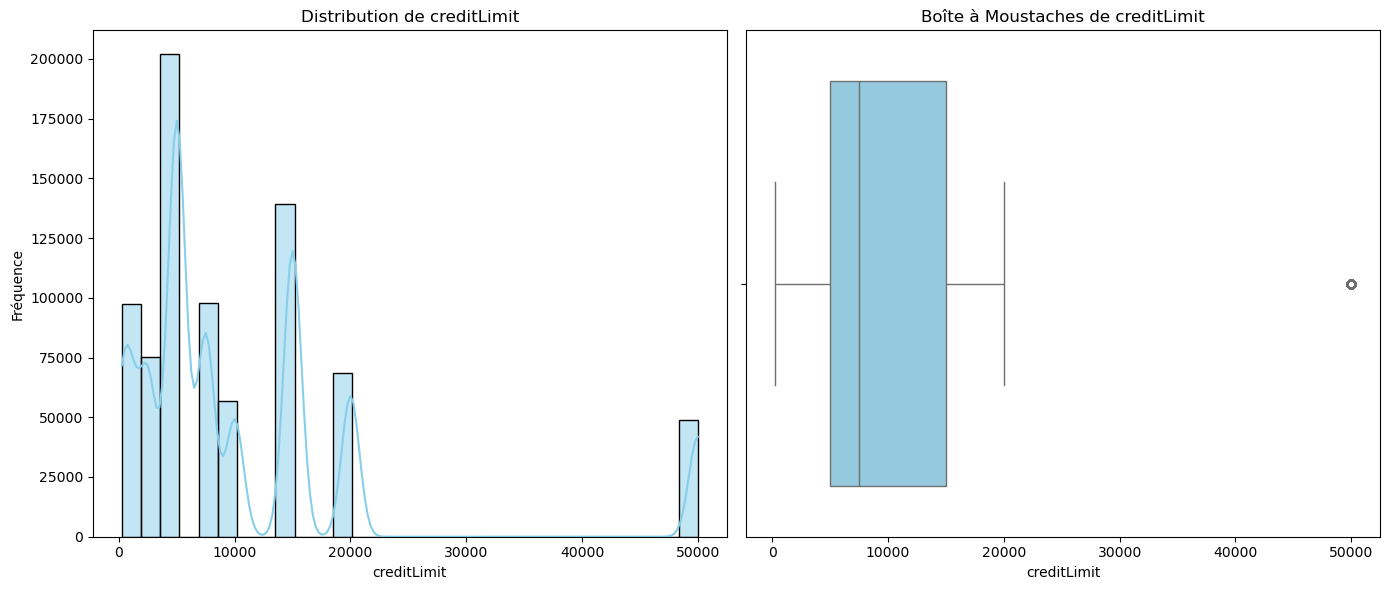

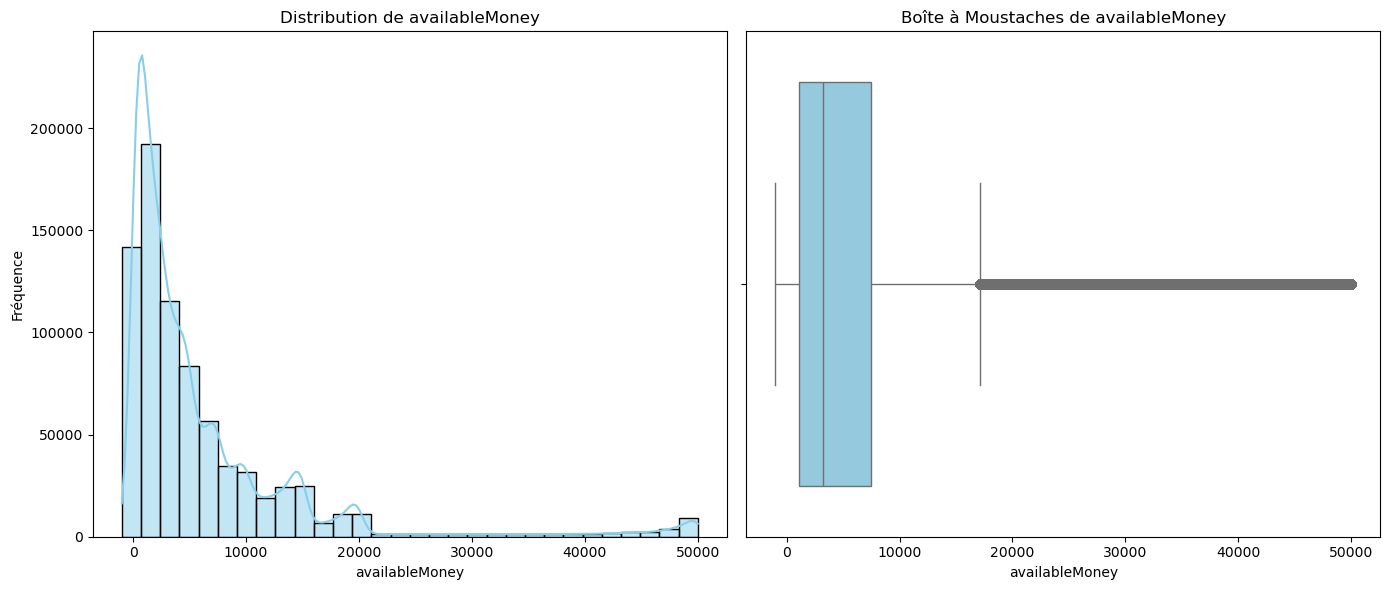

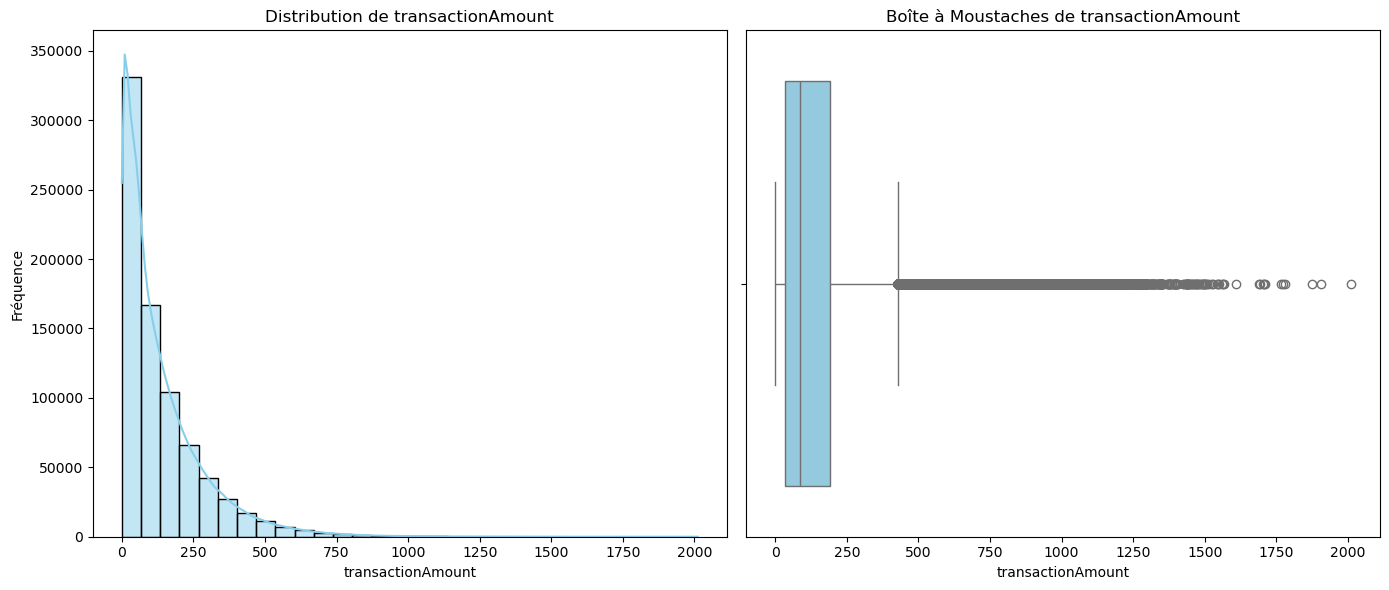

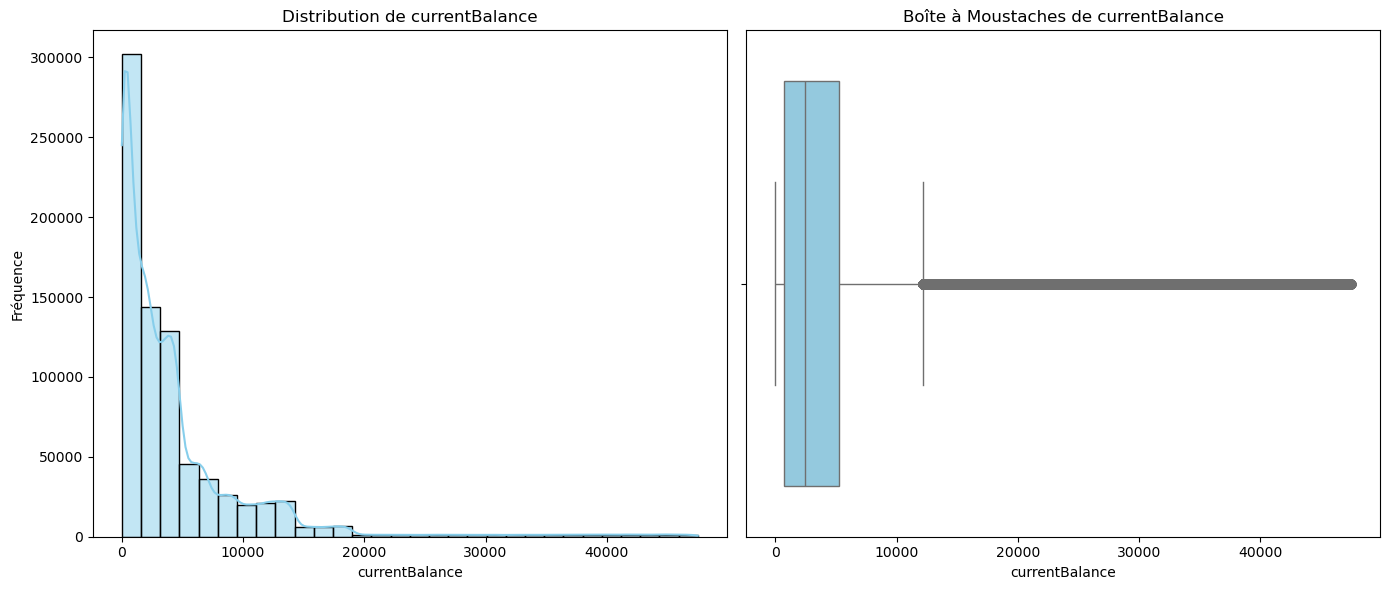

In [9]:
# Variables quantitatives
quant_vars = df_transactions[["creditLimit", "availableMoney", "transactionAmount", "currentBalance"]]

# Distributions et Boîtes à Moustaches
for var in quant_vars:
    plt.figure(figsize=(14, 6))
    
    # Histogramme
    plt.subplot(1, 2, 1)
    sns.histplot(df_transactions[var], bins=30, kde=True, color='skyblue')
    plt.title(f'Distribution de {var}')
    plt.xlabel(var)
    plt.ylabel('Fréquence')
    
    # Boîte à Moustaches
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_transactions[var], color='skyblue')
    plt.title(f'Boîte à Moustaches de {var}')
    
    plt.tight_layout()
    plt.show()


## 3-5- Selection des variables necessaires

In [10]:
# Selection des variables necessaires a l'analyses
data = df_transactions[["creditLimit","availableMoney","transactionAmount","currentBalance"]]
data.head(20)


,creditLimit,availableMoney,transactionAmount,currentBalance
0,5000.0,5000.00,98.55,0.00
1,5000.0,5000.00,74.51,0.00
2,5000.0,5000.00,7.47,0.00
3,5000.0,5000.00,7.47,0.00
4,5000.0,5000.00,71.18,0.00
5,5000.0,5000.00,30.76,0.00
6,5000.0,5000.00,57.28,0.00
7,5000.0,5000.00,9.37,0.00
8,5000.0,4990.63,523.67,9.37
9,5000.0,5000.00,164.37,0.00


## 3-6- Echantillonages des données

Compte tenu de la taille de notre jeu de données (plus de 700.000 lignes) et de la limites de nos ressources nous allons travailler sur un dataset reduit qui represente 5% de notre dataset initial.

Ce travail se deroulera en deux etapes. La premiere consistera a prelever l'echantillon et la seconde consistera a Verifier la distribution de notre echatillon et la comparer a la diistribution du dataset original


In [11]:
# Échantillonnage de 5% des données pour accelerer le temps de traitement
np.random.seed(42)
sampled_indices = np.random.choice(data.shape[0], int(data.shape[0] * 0.05), replace=False)
sampled_data = data.iloc[sampled_indices]

sampled_data.head()


,creditLimit,availableMoney,transactionAmount,currentBalance
297484,5000.0,759.27,141.75,4240.73
646589,250.0,-14.56,43.18,264.56
319743,20000.0,15325.03,144.66,4674.97
713942,5000.0,3903.14,112.12,1096.86
429181,5000.0,1089.20,121.43,3910.80


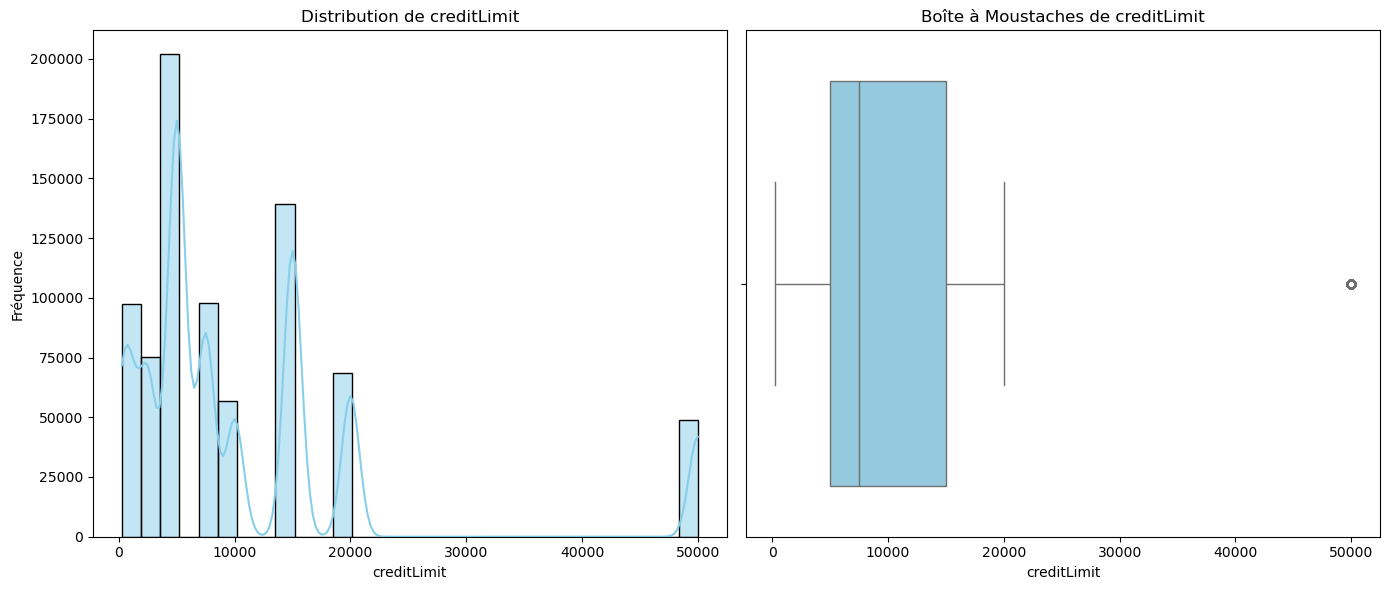

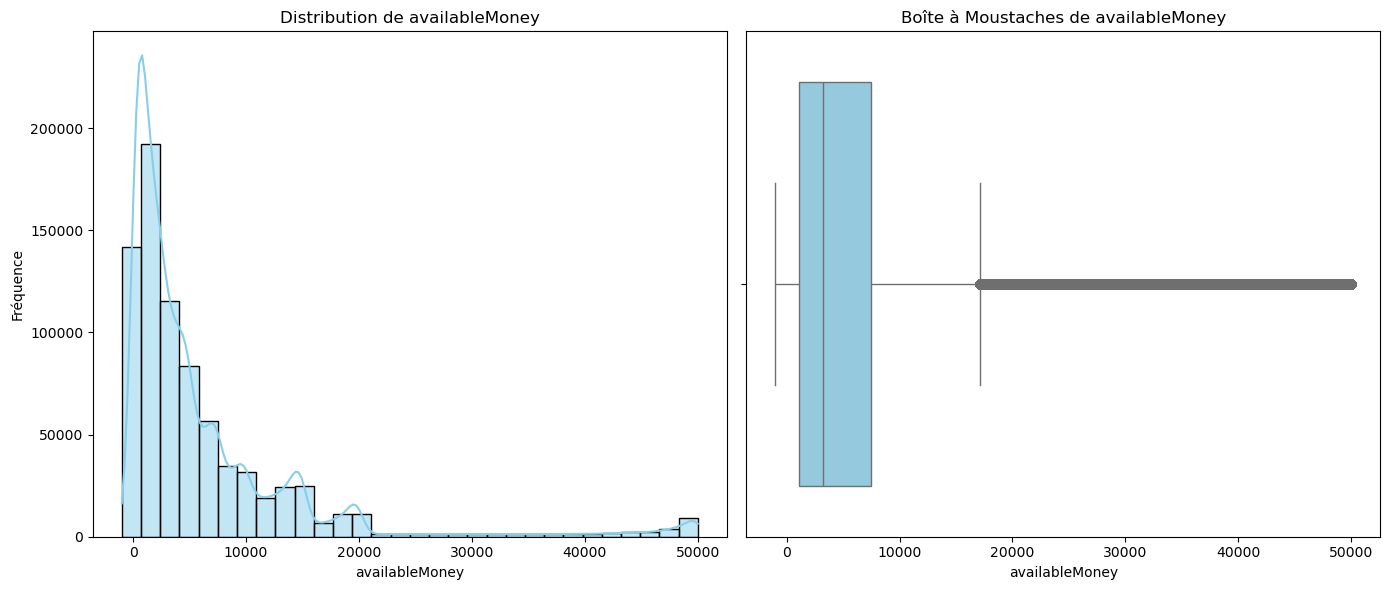

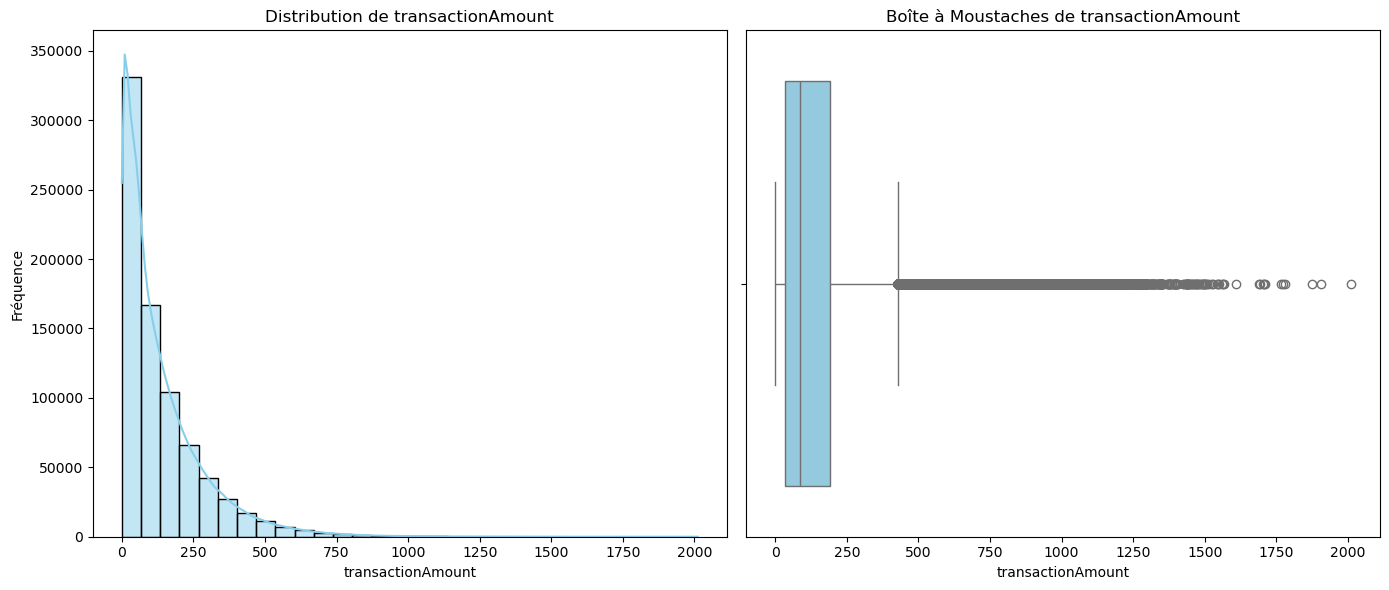

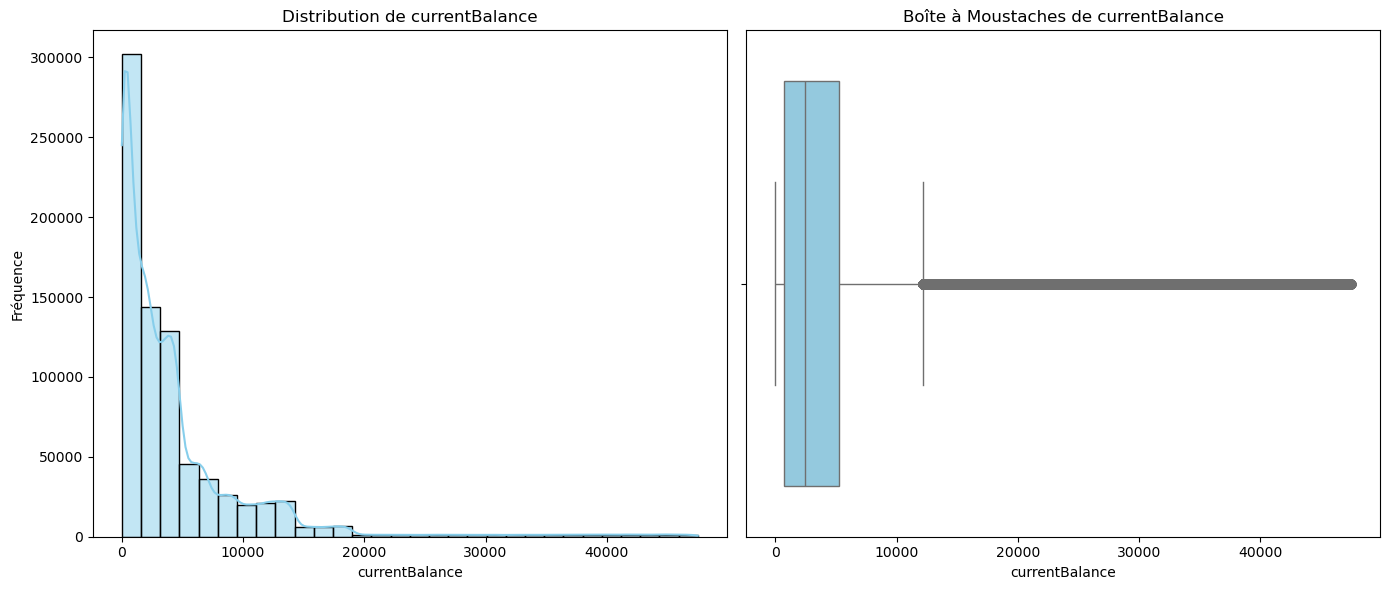

In [12]:
# Verifions la distribution de notre echatillon et comparons la a la diistribution du dataset original
for var in sampled_data:
    plt.figure(figsize=(14, 6))
    
    # Histogramme
    plt.subplot(1, 2, 1)
    sns.histplot(df_transactions[var], bins=30, kde=True, color='skyblue')
    plt.title(f'Distribution de {var}')
    plt.xlabel(var)
    plt.ylabel('Fréquence')
    
    # Boîte à Moustaches
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_transactions[var], color='skyblue')
    plt.title(f'Boîte à Moustaches de {var}')
    
    plt.tight_layout()
    plt.show()


## 3-7- Correlation entre les variables selectionnées

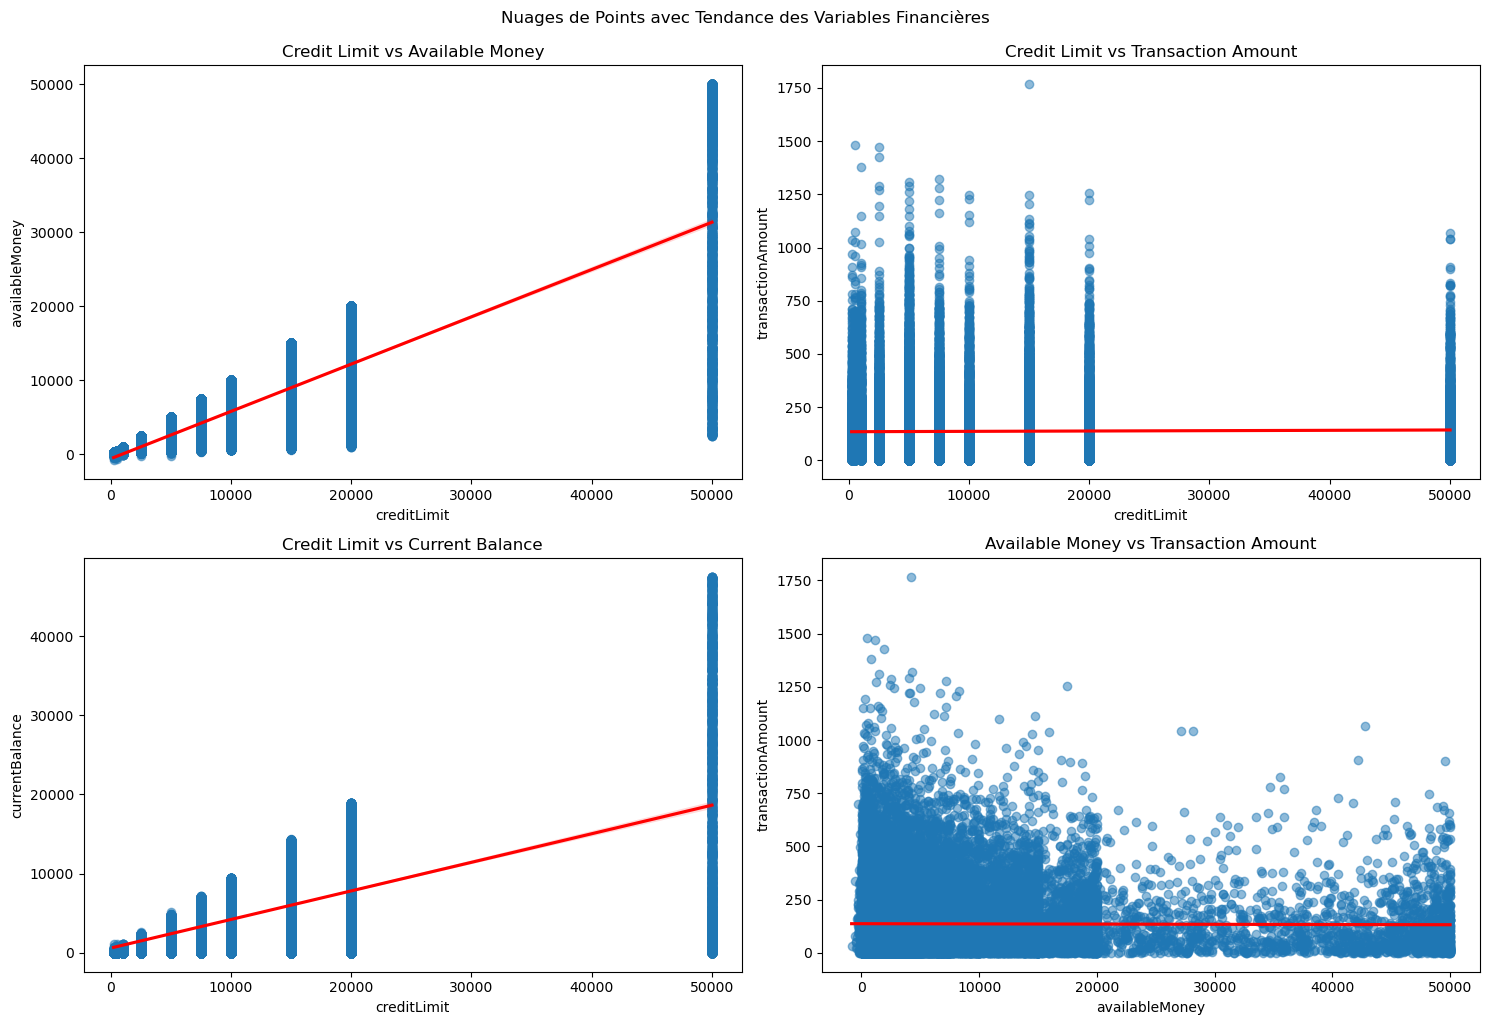

In [13]:
# Evaluons la correlation entre les variables selectionnées
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Générer les scatter plots avec lignes de tendance
sns.regplot(ax=axes[0, 0], x='creditLimit', y='availableMoney', data=sampled_data, scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
axes[0, 0].set_title('Credit Limit vs Available Money')

sns.regplot(ax=axes[0, 1], x='creditLimit', y='transactionAmount', data=sampled_data, scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
axes[0, 1].set_title('Credit Limit vs Transaction Amount')

sns.regplot(ax=axes[1, 0], x='creditLimit', y='currentBalance', data=sampled_data, scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
axes[1, 0].set_title('Credit Limit vs Current Balance')

sns.regplot(ax=axes[1, 1], x='availableMoney', y='transactionAmount', data=sampled_data, scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
axes[1, 1].set_title('Available Money vs Transaction Amount')

plt.tight_layout()
plt.suptitle('Nuages de Points avec Tendance des Variables Financières', y=1.02)
plt.show()


## 3-8- Reduction des variables avec l'ACP

Nous avons selectionnée 04 variables et nous allons les reduire afin d'obtenir 2 composantes. Ce qui nous facilitera le travail par la suite. Dans un premier temps nous allons normaliser les donnees selctionner pour realiser l'ACP, ensuite nous allons appliquer l'ACP pour reduire les données et enfin nous allons normaliser les composantes resultantes de l'ACP pour l'algorithme.


In [14]:
# Normalisation des données pour l'ACP
sc = StandardScaler()
sampled_data_scaled = sc.fit_transform(sampled_data)
sampled_data_scaled


array([[-0.49067197, -0.61494138,  0.03496244, -0.03767753],
       [-0.89682306, -0.70154153, -0.63274507, -0.65273388],
       [ 0.7919104 ,  1.01512871,  0.05467461,  0.02949316],
       ...,
       [-0.49067197, -0.14035666, -0.52768122, -0.69365751],
       [-0.27690824, -0.30025746, -0.07721405, -0.08592552],
       [-0.7044357 , -0.47669873, -0.68131424, -0.6154732 ]])

In [15]:
# Appliquer l'ACP pour reduire nos individus a variables
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(sampled_data_scaled)

pca_df = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
pca_df.head()


,PC1,PC2
0,-0.698740,0.121145
1,-1.322203,-0.608205
2,1.127940,-0.094774
3,-0.729540,-0.198567
4,-0.704046,-0.026459


In [16]:
# Normalisons Les données resultants de l'ACP
pca_array = pca_df.values 
sc = StandardScaler()
sampled_pca_array = sc.fit_transform(pca_array)
sampled_pca_array


array([[-0.47906743,  0.12081016],
       [-0.90652422, -0.6065248 ],
       [ 0.7733343 , -0.09451174],
       ...,
       [-0.51111271, -0.59403375],
       [-0.27402405, -0.04275649],
       [-0.71824875, -0.68221437]])

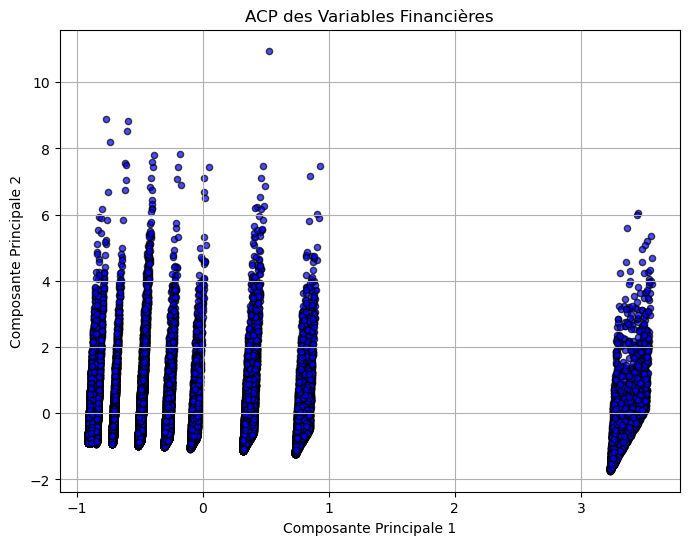

In [17]:
# Affichage du dataset
plt.figure(figsize=(8, 6))
plt.scatter(sampled_pca_array[:, 0], sampled_pca_array[:, 1], s=20, c='blue', alpha=0.7, edgecolor='k')
plt.title("ACP des Variables Financières")
plt.xlabel("Composante Principale 1")
plt.ylabel("Composante Principale 2")
plt.grid(True)
plt.show()


# 4- <u>Implementation</u>

Compte tenu du fait que l'algorithme des SNN s'execute avec d'autres algorithme de clustering comme K-Means ou DBSCAN, nous allons precoder en plusieurs etapes

## 4-1- Determination du coude pour choisir le bon K

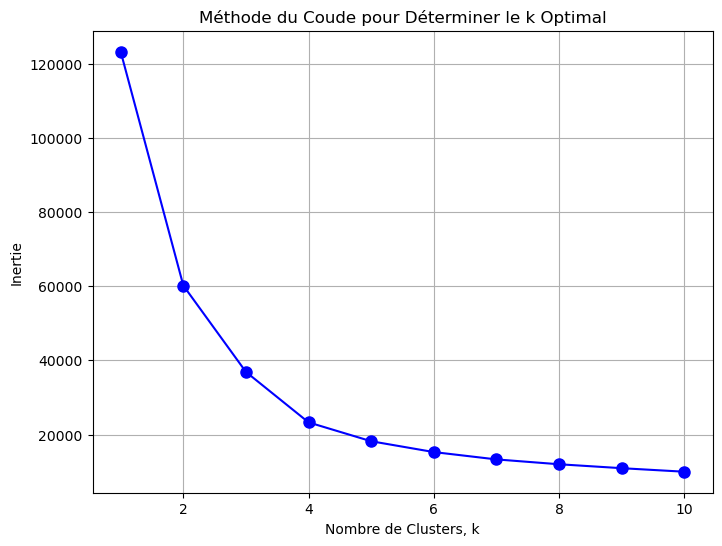

In [18]:
def determine_elbow(pca_array, max_k=10):
    # Liste pour stocker les inerties
    inertias = []

    # Calculer l'inertie pour chaque k
    for k in range(1, max_k+1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(pca_array)
        inertias.append(kmeans.inertia_)

    # Tracer la courbe du coude
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, max_k+1), inertias, 'bo-', markersize=8)
    plt.xlabel('Nombre de Clusters, k')
    plt.ylabel('Inertie')
    plt.title('Méthode du Coude pour Déterminer le k Optimal')
    plt.grid(True)
    plt.show()

# Appliquer la méthode du coude sur tes données PCA
determine_elbow(pca_array, max_k=10)


## 4-2- Implementation de l'algorithme SNN

In [19]:
# Algorithme SNN Clustering
def snn_clustering(sampled_pca_array, k , min_shared_neighbors):
    
    # Étape 1: Trouver les k-plus proches voisins
    nn_model = NearestNeighbors(n_neighbors=k).fit(sampled_pca_array)
    distances, neighbors = nn_model.kneighbors(sampled_pca_array)
    
    # Étape 2: Construire une matrice de similarité SNN
    n = sampled_pca_array.shape[0]
    similarity_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i + 1, n):  # Matrice symétrique
            shared_neighbors = len(set(neighbors[i]) & set(neighbors[j]))
            similarity_matrix[i, j] = shared_neighbors
            similarity_matrix[j, i] = shared_neighbors

    # Étape 3: Clusterisation basée sur le seuil de similarité
    visited = np.zeros(n, dtype=bool)
    clusters = np.full(n, -1, dtype=int)
    cluster_id = 0

    def expand_cluster(point_idx):
        """Explore les voisins pour étendre un cluster."""
        queue = [point_idx]
        clusters[point_idx] = cluster_id

        while queue:
            current = queue.pop(0)
            for neighbor_idx in range(n):
                if similarity_matrix[current, neighbor_idx] >= min_shared_neighbors:
                    if not visited[neighbor_idx]:
                        visited[neighbor_idx] = True
                        queue.append(neighbor_idx)
                    if clusters[neighbor_idx] == -1:
                        clusters[neighbor_idx] = cluster_id

    for point_idx in range(n):
        if not visited[point_idx]:
            visited[point_idx] = True
            if similarity_matrix[point_idx].sum() >= min_shared_neighbors:
                expand_cluster(point_idx)
                cluster_id += 1

    return clusters
    

## 4-3- Implementation de l'algorithme KMeans

In [20]:
# K-Means Clustering
def kmeans_clustering(sampled_pca_array, n_clusters=4):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    return kmeans.fit_predict(sampled_pca_array)
    

## 4-4- Implementation de l'algorithme DBSCAN

In [21]:
# DBSCAN Clustering
def dbscan_clustering(sampled_pca_array, eps, min_samples=5):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    return dbscan.fit_predict(sampled_pca_array)


## 4-5- Fonction pour afficher les resultats

In [22]:
def plot_results(sampled_pca_array, snn_labels, kmeans_labels, dbscan_labels):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].scatter(sampled_pca_array[:, 0], sampled_pca_array[:, 1], c=snn_labels, cmap='rainbow', s=20)
    axes[0].set_title("SNN Clustering")
    axes[1].scatter(sampled_pca_array[:, 0], sampled_pca_array[:, 1], c=kmeans_labels, cmap='rainbow', s=20)
    axes[1].set_title("K-Means Clustering")
    axes[2].scatter(sampled_pca_array[:, 0], sampled_pca_array[:, 1], c=dbscan_labels, cmap='rainbow', s=20)
    axes[2].set_title("DBSCAN Clustering")
    plt.show()


## 4-6- Appel des nos algorithmes et visualisation des resultats

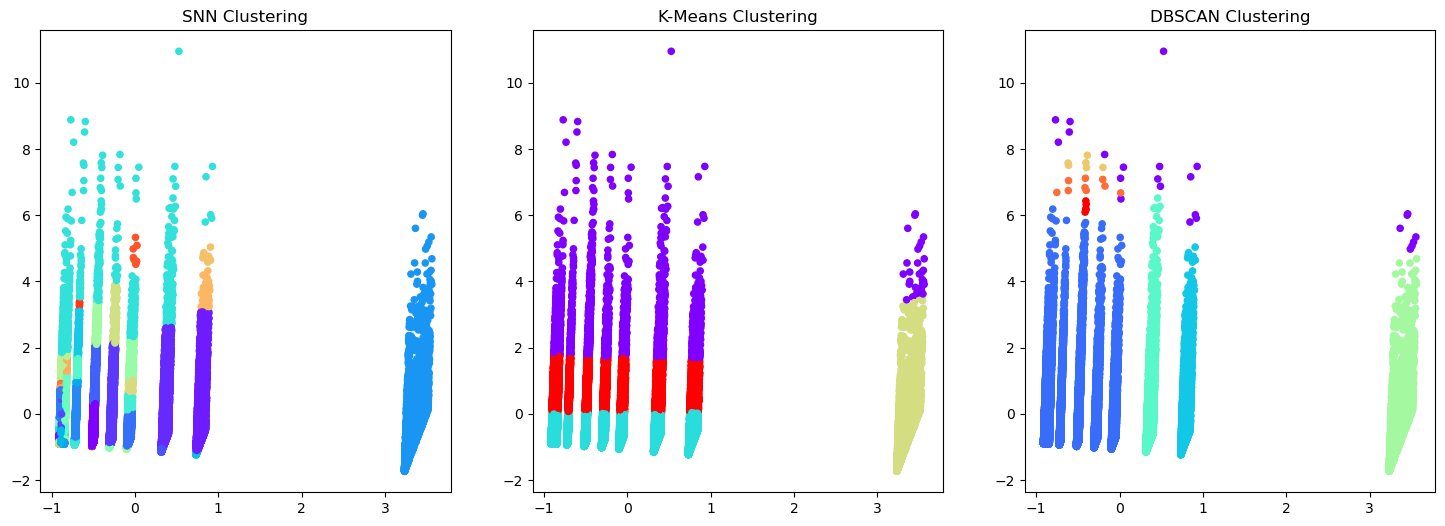

In [23]:
# Appliquer SNN, K-Means et DBSCAN
snn_labels = snn_clustering(sampled_pca_array, k=13, min_shared_neighbors=7)
kmeans_labels = kmeans_clustering(sampled_pca_array, n_clusters=4)
dbscan_labels = dbscan_clustering(sampled_pca_array, eps=0.3, min_samples=5)

# Résultats visuels
plot_results(sampled_pca_array, snn_labels, kmeans_labels, dbscan_labels)

# 5- <u> Evaluation</u>

## 5-1- Silhouette

In [31]:
silhouette_snn = silhouette_score(sampled_pca_array, snn_labels)
silhouette_kmeans = silhouette_score(sampled_pca_array, kmeans_labels)
silhouette_dbscan = silhouette_score(sampled_pca_array, dbscan_labels)

print(f'Le coefficient de Silhouette pour SNN: {silhouette_snn}')
print(f'le coefficient de Silhouette pour K-Means: {silhouette_kmeans}')
print(f'le coefficient de Silhouette pour DBSCAN: {silhouette_dbscan}')


Le coefficient de Silhouette pour SNN: -0.3173631377090271
le coefficient de Silhouette pour K-Means: 0.43906695589051586
le coefficient de Silhouette pour DBSCAN: 0.2578064659024312


- **Coefficient de Silhouette pour SNN : -0.3173631377090271**

Un coefficient de silhouette négatif (-0.32) indique que, pour notre algorithme SNN, beaucoup de points sont plus proches de clusters autres que le leur. Cela suggère que les clusters formés par SNN ne sont pas bien définis et que les points sont être mal assignés.

- **Coefficient de Silhouette pour K-Means : 0.43906695589051586**

Un coefficient de silhouette de 0.44 pour K-Means suggère que les clusters sont relativement bien définis. Les points sont plus proches de leur propre cluster par rapport aux clusters voisins, ce qui indique une bonne qualité de clustering.

- **Coefficient de Silhouette pour DBSCAN : 0.2578064659024312**

Un coefficient de silhouette de 0.26 pour DBSCAN indique une qualité de clustering intermédiaire. Les clusters sont modérément bien définis, mais il peut y avoir des chevauchements ou des points mal assignés.

## 5-2- Davies Bouldin

In [28]:
db_snn = davies_bouldin_score(sampled_pca_array, snn_labels)
db_kmeans = davies_bouldin_score(sampled_pca_array, kmeans_labels)
db_dbscan = davies_bouldin_score(sampled_pca_array, dbscan_labels)

print(f"l'indice de Davies-Bouldin pour SNN: {db_snn}")
print(f"l'indice de Davies-Bouldin pour K-Means: {db_kmeans}")
print(f"l'indice de Davies-Bouldin pour DBSCAN: {db_dbscan}")


l'indice de Davies-Bouldin pour SNN: 2.3212563716669163
l'indice de Davies-Bouldin pour K-Means: 0.7781943168444622
l'indice de Davies-Bouldin pour DBSCAN: 1.8036513174217634


- **Indice de Davies-Bouldin pour SNN : 2.3212563716669163**

Un IDB de 2.32 pour SNN suggère que les clusters formés par l'algorithme SNN ne sont pas aussi compacts ou bien séparés que ceux des autres algorithmes. Cela indique que l'algorithme a du mal à identifier des clusters bien définis avec les paramètres actuels. La qualité du clustering est moins bonne avec une plus grande dispersion et une moins bonne séparation des clusters. Il peut être utile d'ajuster les paramètres dans notre cas mais nous nous limiterons a ces resultats compte tenu de notre puissance de calcul.

- **Indice de Davies-Bouldin pour K-Means : 0.7781943168444622**

Un IDB de 0.78 pour K-Means est relativement bas, ce qui suggère que les clusters formés par K-Means sont bien compacts et séparés. K-Means semble avoir bien fonctionné avec les données et les paramètres fournis, identifiant des clusters distincts. Cet algorithme a fourni le meilleur résultat en termes de compacité et de séparation des clusters. Il semble bien adapté a nos données actuelles.

- **Indice de Davies-Bouldin pour DBSCAN : 1.8036513174217634**

Un IDB de 1.80 pour DBSCAN indique une qualité de clustering intermédiaire. La valeur intermédiaire du DBI peut refléter la présence de bruit ou des clusters avec des densités variées, ce qui pourrait être dû à la nature des données ou à la présence de bruit
